In [2]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.spatial.distance as distance
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
%matplotlib inline
import seaborn as sns
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.utils import to_categorical
from keras.regularizers import Regularizer

import keras.backend as K
import keras.regularizers as regularizers
from sklearn.preprocessing import StandardScaler,OneHotEncoder

import statsmodels.api as sm

/home/elijahc/.pyenv/versions/3.5.2/envs/jupyterlab/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/elijahc/.pyenv/versions/3.5.2/envs/jupyterlab/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### "invert" network to find optimal inputs
- Load model weights
- Make weights untrainable
- Add "pseudo" dense layer of linear activations and constant 0 biases between input and first layer
- Train on batches of all 1's so the learned weights are the "preferred" inputs
- Reverse transform learned weights to get relative frequency power

In [3]:
class MahalinobisDistance(Regularizer):
    def __init__(self,VI,mu,l=0.01):
        self.VI = K.constant(VI)
        self.mu = K.constant(mu)
        self.l = l
    
    def __call__(self,weights):
        diff = weights-self.mu
        distance = K.dot(K.dot(diff,self.VI),K.transpose(diff))
        
        return K.abs(self.l*K.sum(K.sqrt(distance)))

In [4]:
def merge_nrem_state(states):
    return np.array([2 if s in [1,2,3] else s for s in states])

def merge_data(records,merge_keys=None,simple=False):
    merged_data = {}
    for k in merge_keys:
        merged_data[k] = np.concatenate( [d[k] for d in records] )
    if simple:
        merged_data['stages_simple'] = merge_nrem_state(merged_data['stages'][:,2])
    return merged_data

def load_preprocessed(
        data_path='/home/elijahc/data/uminn/preprocessed',
        merge_keys=None,
        simple=False,
        file_names=[
            'band_pow1.mat',
            'band_pow2.mat',
            'band_pow3.mat',
            'band_pow4.mat',
            'band_pow5.mat',
            'band_pow6.mat',
            'band_pow7.mat',
            'band_pow8.mat',
            'band_pow9.mat',
            # 'band_pow10.mat',
            ]):

    file_paths = [os.path.join(data_path,fname) for fname in file_names]
    all_data = [ sio.loadmat(fp) for fp in file_paths ]
    if merge_keys is not None:
        return merge_data(all_data,merge_keys,simple)
    else:
        if simple:
            for d in all_data:
                d['stages_simple']=merge_nrem_state(d['stages'][:,2])
        return all_data

def feedforward(layer_spec=[64],num_labels=5,activ='sigmoid',
                optim='adam',loss='categorical_crossentropy',
                droprate=None,loss_weights=None,reg_weight=0.01):
    model = Sequential()
    input_shape = (8,)
    for i,units in enumerate(layer_spec):
        if i == 0:
            d_layer = Dense(units,activation=activ,kernel_regularizer=regularizers.l1(reg_weight),input_shape=input_shape)
        else:
            d_layer = Dense(units,activation=activ,kernel_regularizer=regularizers.l1(reg_weight))
        model.add(d_layer)
        if droprate is not None:
            model.add(Dropout(droprate))

    model.add(Dense(num_labels,activation='softmax'))

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=optim,
                loss=loss,
                loss_weights=loss_weights,
                metrics=['categorical_accuracy'])
    
    return model

def invert_model(in_model,input_shape,loss='categorical_crossentropy',cov=None,reg_l=0.01):
    reg = None
    if cov is not None:
        VI = np.linalg.inv(cov)
        mu = np.zeros(shape=(1,8))
        reg = MahalinobisDistance(VI=VI,mu=mu,l=reg_l)
    
    pd_input = Input(shape=input_shape)
    
    pseudo_dense = Dense(8,use_bias=False,kernel_regularizer=reg)(pd_input)

    x = in_model.layers[0](pseudo_dense)
    output = in_model.layers[1](x)
    out_model = Model(inputs=pd_input,outputs=output)
    out_model.compile(optimizer='nadam',loss=loss,metrics=['categorical_accuracy'])
    return out_model

def reset_weights(model,layer_idxs=None):
    session = K.get_session()
    model_layers = model.layers
    num_layers = len(model_layers)
    if layer_idxs is not None:
        iter_layers = np.array(layer_idxs)
    else:
        iter_layers = np.arange(num_layers)
    for l_idx in iter_layers: 
        layer = model_layers[l_idx]
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            
def get_inverse_freq_weights(labels,sqrt=False):
    label_bct = np.bincount(labels)
    label_pct = label_bct/label_bct.sum()
    nz = np.nonzero(label_pct)[0].tolist()
    sparse_weights = 1/label_pct[np.nonzero(label_pct)]
    sample_weights = np.array([ sparse_weights[nz.index(s)] for s in labels ])
    if sqrt:
        return np.sqrt(sample_weights)
    else:
        return sample_weights

In [5]:
dat = load_preprocessed(simple=True,merge_keys=['stages','pows'])
all_data = load_preprocessed(simple=True)
scaler = StandardScaler()
oh_encoder = OneHotEncoder()
scaled_X = scaler.fit_transform(dat['pows'])
labels = dat['stages_simple']
trans_dat = scaled_X
oh_Y = oh_encoder.fit_transform(labels.reshape(-1,1)).toarray()
ex_weight = get_inverse_freq_weights(dat['stages_simple'],sqrt=True)
oh_Y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [6]:
train_idxs = np.load('/home/elijahc/dev/sleep_augur/train_idxs.npy')
test_idxs = np.load('/home/elijahc/dev/sleep_augur/test_idxs.npy')
groups = [ [i]*len(d['pows']) for i,d in zip(np.arange(len(all_data)),all_data) ]
groups = np.concatenate(groups,axis=0)


In [8]:
np.save('./pt_groups.npy',groups)

In [6]:
trans_dat.shape
dat_cov = np.cov(trans_dat.T)


array([1.4384755, 1.4384755, 1.4384755, ..., 1.4384755, 1.4384755,
       1.4384755])

In [8]:
mod_params = dict(
    layer_spec=[32],
    activ='relu',
    optim='nadam',
    num_labels=3
)
root_path = '/home/elijahc/dev/sleep_augur/results/2017-09-18'
weights = [root_path+"/pt%d_model.h5"%i for i in np.arange(9)]
null_models = [feedforward(**mod_params) for w in weights]
models = [feedforward(**mod_params) for w in weights]
# m = feedforward(**mod_params)
for m,w in zip(models,weights):
    m.load_weights(w)
    for l in m.layers:
        l.trainable = False
    
# models = [invert_model(m,input_shape=(8,)) for m in models]        
print(models[0].summary())
# m =  models[0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_56 (Dense)             (None, 3)                 99        
Total params: 387
Trainable params: 0
Non-trainable params: 387
_________________________________________________________________
None


In [9]:
K.variable(np.random.rand(1,8))

<tf.Variable 'Variable:0' shape=(1, 8) dtype=float32_ref>

In [10]:
m = invert_model(null_models[0],input_shape=(1,),loss='kullback_leibler_divergence',cov=dat_cov,reg_l=1)
# m.layers[1].get_weights()[0].shape
test_weight = np.random.rand(1,8)
np_mh_dist = distance.mahalanobis(test_weight,np.zeros(shape=(1,8)),VI=np.linalg.inv(dat_cov))
print(np_mh_dist)
reg_mh_dist = K.get_value(m.layers[1].kernel_regularizer(K.variable(test_weight)))
print(reg_mh_dist)

2.377971881996197
2.377972


In [66]:
def eval_models(scaled_X,oh_Y,models,test_idxs,train_idxs,weights=None):
    weighted = False
    full = np.arange(scaled_X.shape[0]).tolist()
#     print(full)
    if weights is None:
            weighted=True
            weights = np.array([None]*len(full))
            
    recs = []
    for pt_idx,m in enumerate(models):
        test = test_idxs[pt_idx]
        train = train_idxs[pt_idx]
        
        params = [dict(x=scaled_X[subset],y=oh_Y[subset],sample_weight=weights[subset]) for subset in [test,full]]
        
        results = [m.evaluate(**p) for p in params]
        subset = ['test','full']
        for set_lab,res in zip(subset,results):
            rec = dict(
                model_id=pt_idx,
                data_set=set_lab,
                accuracy=res[1],
                loss=res[0],
                weighted=weighted,
            )
            recs.append(rec)
    return pd.DataFrame.from_records(recs)

print('unweighted')
unweighted_df = eval_models(scaled_X,oh_Y,models,test_idxs,train_idxs)
print('weighted')
weighted_df = eval_models(scaled_X,oh_Y,models,test_idxs,train_idxs,weights=ex_weight)

unweighted
7534/7534 [==============================] - 0s 34us/step
weighted
7534/7534 [==============================] - 0s 29us/step


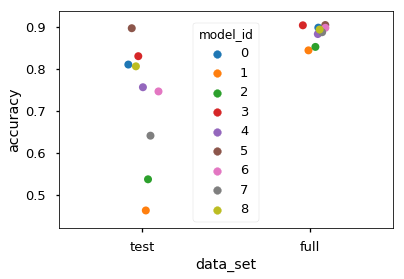

In [72]:
sns.set_context('talk')
sns.stripplot(x='data_set',y='accuracy',hue='model_id',data=weighted_df,jitter=True,size=8,)

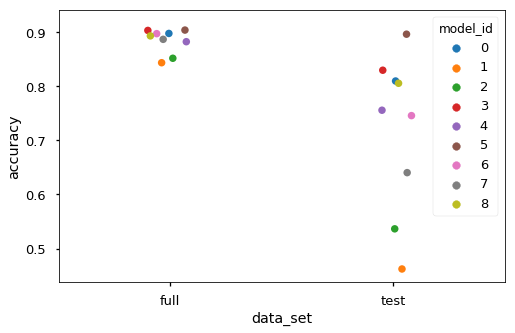

In [87]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
sns.stripplot(x='data_set',y='accuracy',hue='model_id',order=['full','test'],data=unweighted_df,jitter=True,size=7.5,ax=ax)

fig.savefig('model_generalization.png',dpi=300,)

In [94]:
df = weighted_df
good_models = df[(df.accuracy>0.8) & (df.data_set=='test')].model_id.values
good_models

array([0, 3, 5, 8])

In [168]:
num_train_examples=60000
num_trials=3
fake_Y = np.ones(shape=(num_train_examples,1))
fake_X = np.ones(shape=(num_train_examples,1,))
fake_Y_null = np.ones(shape=(num_train_examples,3))*0.33
null_optim = np.empty(shape=(num_trials,9,8))
inp_optim = np.zeros(shape=(3,9,8))
out_vals = [0,2,5]

In [169]:
# Train null models
# zip(np.arange(9),null_models)
for i_m in tqdm(np.arange(9)):
    mod = models[i_m]
    m = invert_model(mod,input_shape=(1,),loss='mean_squared_error')
    for i in np.arange(num_trials):
        reset_weights(m,layer_idxs=[1])
        Y = oh_encoder.transform(fake_Y*out_vals[i]).toarray()
        m.fit(x=fake_X,y=Y,batch_size=128,epochs=3,verbose=0)
        optim = K.get_value(m.layers[1].weights[0])
        inp_optim[i,i_m] = optim
        print(optim)
        print(models[i_m].predict(x=optim))
        


  0%|          | 0/9 [00:00<?, ?it/s]
Exception in thread Thread-11:
Traceback (most recent call last):
  File "/home/elijahc/.pyenv/versions/3.5.2/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/elijahc/.pyenv/versions/3.5.2/envs/jupyterlab/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/elijahc/.pyenv/versions/3.5.2/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[[-0.5131043  -0.33557212 -1.0203786   0.920348    0.98485935  0.30814072
   0.48371217 -0.68481535]]
[[9.9239445e-01 7.5400500e-03 6.5588887e-05]]
[[ 0.2127175  -0.17661692  0.12897448  0.18166602 -0.00804473 -0.04276285
   0.466031   -0.36740386]]
[[0.01918257 0.97828716 0.0025302 ]]


 11%|█         | 1/9 [00:09<01:15,  9.43s/it]

[[ 0.34654555  0.58931816 -0.14854956  0.1175735  -0.30367303  1.0665536
  -0.29854715  0.979383  ]]
[[0.01974326 0.01405003 0.9662067 ]]
[[ 0.12967347  0.22536871 -0.9383821  -0.57522905 -0.06660862  0.42831236
  -1.0349486   1.1765317 ]]
[[9.8461413e-01 7.7057448e-05 1.5308725e-02]]
[[ 0.9072941   0.46533656 -0.58431566  0.64759004  0.02656485  0.74122965
   0.1900926  -0.10702921]]
[[0.00744519 0.97885096 0.0137039 ]]


 22%|██▏       | 2/9 [00:18<01:04,  9.24s/it]

[[-0.03833599 -0.00270593  0.07937089  0.33861676  0.16296385 -0.4741165
   0.7373881   0.36199898]]
[[9.7258732e-04 1.0676834e-02 9.8835063e-01]]
[[-0.9146675  -0.14213862 -0.06328459  1.1651374  -0.16324171  0.02378317
   0.7698014  -0.8450707 ]]
[[0.99565756 0.00226845 0.00207402]]
[[ 0.47854427  0.6874667   0.6797241   1.4692434  -0.25757223  0.6209405
   0.43879077 -0.51722336]]
[[0.01975772 0.9734621  0.00678021]]


 33%|███▎      | 3/9 [00:27<00:55,  9.27s/it]

[[-0.21824975  1.0155131  -1.2233405  -0.44695616  0.2731153   0.3349233
  -0.33495006 -0.01295858]]
[[0.00182508 0.00664147 0.99153346]]
[[-0.5229931  -0.66426176  0.7931909  -0.00818564  0.8821854  -0.5272304
  -0.8418792   0.3657394 ]]
[[9.8907018e-01 7.2691801e-06 1.0922505e-02]]
[[ 0.18061122 -0.43581516  0.7261386   0.71247566  0.5168375  -0.1899269
   0.34596777 -0.22627595]]
[[0.01121058 0.9847707  0.00401858]]


 44%|████▍     | 4/9 [00:37<00:46,  9.35s/it]

[[-0.70522326  0.20763841 -0.60309124 -0.06626227 -0.12866256 -0.5400404
  -0.20819336  0.14516523]]
[[0.03103347 0.00729399 0.96167254]]
[[ 0.20187947 -0.5954414   0.16182502 -0.55273503  0.10144116 -0.53128463
   0.80940396  0.82609206]]
[[9.87949610e-01 1.20478505e-02 2.64113532e-06]]
[[ 0.7074718   0.26104662  0.5456274  -0.21197245  0.3090859   0.28433105
  -0.1907919  -0.46720466]]
[[0.00283636 0.9674529  0.02971072]]


 56%|█████▌    | 5/9 [00:47<00:37,  9.44s/it]

[[-0.4233691   0.40023848 -1.096486   -0.26764095 -0.4613429   0.4345913
   0.08862468  0.05717349]]
[[0.03886452 0.01898629 0.94214916]]
[[ 0.5869215  -0.619017   -0.3435356  -0.04099418 -0.8041441   0.51912206
   0.08486979 -0.15592015]]
[[9.9999619e-01 3.6592953e-06 9.4312959e-08]]
[[ 0.2240598   0.03274137  0.17231229 -0.3930244  -0.54030865 -0.3698848
   0.45621157 -0.7565134 ]]
[[3.7267001e-04 9.9960631e-01 2.1128137e-05]]


 67%|██████▋   | 6/9 [00:57<00:28,  9.53s/it]

[[ 0.75328845  0.7984553  -0.60540545 -0.2299983   0.251332   -0.4583542
   0.6760244  -0.77870923]]
[[1.07101619e-06 9.99998808e-01 1.17052075e-07]]
[[-0.65638965 -0.24307853  0.8472106  -0.26940823 -0.44029358 -0.24466622
   0.8842365   0.20392115]]
[[0.98686117 0.0048919  0.00824689]]
[[ 0.6571727  -0.5694366   0.6648667   0.71766233  0.00846773  0.15527955
  -0.19764267 -0.42229247]]
[[9.8921144e-03 9.8997784e-01 1.3006869e-04]]


 78%|███████▊  | 7/9 [01:06<00:19,  9.56s/it]

[[-0.5646438   0.00327955  0.31070462 -0.6176079   0.495185    0.3100338
   0.07811743 -0.22335066]]
[[0.00509842 0.00387938 0.99102217]]
[[ 0.34073135 -0.9598811   1.0373346  -0.8661651   0.875218    0.45452383
  -0.2793261   0.0617962 ]]
[[9.8287731e-01 1.7122615e-02 6.7083853e-08]]
[[ 1.2254857  -0.2151551   1.1693779   0.96068776  0.02502716 -0.13100658
   0.19113345 -0.06329512]]
[[7.9018000e-04 9.7911650e-01 2.0093316e-02]]


 89%|████████▉ | 8/9 [01:16<00:09,  9.58s/it]

[[-0.08046631 -0.06949507 -0.45100737 -0.9841094   0.9506317   0.40291166
  -0.18955854  0.7078584 ]]
[[0.02124905 0.01549485 0.96325606]]
[[-0.82871205  0.02939841 -0.27372533  1.0438877  -0.11084366 -0.5036001
   0.24571761  0.92107636]]
[[0.9745963  0.01172617 0.01367749]]
[[ 0.6036212  -0.15489957  0.05744284  0.62715375  0.23056914 -0.43820223
  -0.654281   -0.51399344]]
[[0.00179043 0.99586403 0.00234551]]


100%|██████████| 9/9 [01:26<00:00,  9.58s/it]

[[-0.02854495 -0.34897956 -1.0002992   0.2517971  -0.25128564  0.6992445
  -0.65144026  0.5661418 ]]
[[0.02073741 0.01368566 0.96557695]]


In [166]:
test_df = weighted_df[weighted_df.data_set=='test']
test_df['acc_weight']=1/(1-test_df.accuracy)
test_df.head()

/home/elijahc/.pyenv/versions/3.5.2/envs/jupyterlab/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,accuracy,data_set,loss,model_id,weighted,acc_weight
0,0.809926,test,1.337600,0,False,5.261111
2,0.462141,test,4.647400,1,False,1.859223
4,0.536417,test,1.436308,2,False,2.157113
6,0.829882,test,1.464804,3,False,5.878261
8,0.755882,test,1.227513,4,False,4.096386


In [170]:
np.save('/home/elijahc/projects/lfp/optim_inputs.npy',inp_optim)

In [190]:
w = test_df.acc_weight.values
w = np.swapaxes(np.tile(w.reshape(-1,1),3),0,1)
print(w.shape)
band_weighted_mu = np.empty(shape=(3,8))
for b in np.arange(8):
    band_weighted_mu[:,b]=np.average(inp_optim[:,:,b],axis=1)

# np.average(inp_optim,axis=-1,weights=w).shape

(3, 9)


In [197]:
mu_recs = []
for i,lab in enumerate(band_label):
    for j,stg in enumerate(stages):
        mu_recs.append(dict(
            stage=stg,
            band=lab,
            z_power=band_weighted_mu[j,i],
            power=scaler.inverse_transform(band_weighted_mu)[j,i]))
df_mu = pd.DataFrame.from_records(mu_recs)
df_mu.head()

,band,power,stage,z_power
0,delta,9.671155e-07,Wake,-0.241851
1,delta,3.546730e-06,NREM,0.577442
2,delta,1.393106e-06,REM,-0.106555
3,theta,6.563024e-07,Wake,-0.367180
4,theta,1.659510e-06,NREM,-0.011704


In [131]:
band_mean = inp_optim.reshape(3*9,8).mean(axis=0,)
band_std = inp_optim.reshape(3*9,8).std(axis=0)

In [211]:
recs = []
band_label=[
    'delta',
    'theta',
    'alpha',
    'beta',
    'gamma_1',
    'gamma_2',
    'gamma_3',
    'hi_freq',
]

stages = ['Wake','NREM','REM']
for i in np.arange(3):
    for j in np.arange(9):
        z_score=np.abs((inp_optim[i,j]-band_mean)/band_std)
        for b in np.arange(8):
            r = dict(
                band_label=band_label[b],
                norm_val=inp_optim[i,j,b],
                band_power=scaler.inverse_transform(inp_optim[i,j])[b],
                model=j,
                stage=stages[i],
                z_score=z_score[b]
            )
            recs.append(r)
optim_df = pd.DataFrame.from_records(recs)
optim_df['log10_power']=np.log10(optim_df.band_power)
optim_df.head()

/home/elijahc/.pyenv/versions/3.5.2/envs/jupyterlab/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log10


,band_label,band_power,model,norm_val,stage,z_score,log10_power
0,delta,1.130519e-07,0,-0.513104,Wake,1.220755,-6.946722
1,theta,7.455055e-07,0,-0.335572,Wake,1.150051,-6.127549
2,alpha,-3.153514e-07,0,-1.020379,Wake,1.092290,NaN
3,beta,1.232792e-06,0,0.920348,Wake,1.584509,-5.909110
4,gamma_1,1.421488e-06,0,0.984859,Wake,1.199902,-5.847257


In [221]:
good_models = test_df[test_df.accuracy>0.70].model_id.values


[0 3 4 5 6 8]


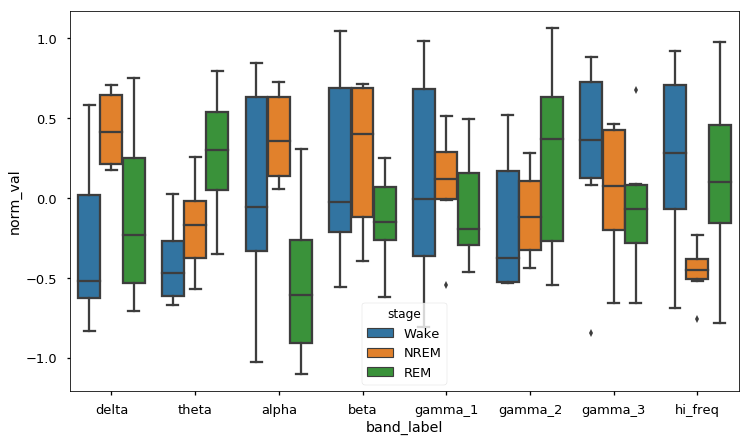

In [222]:
fig,ax = plt.subplots(1,1,figsize=(12,7))
sns.boxplot(x='band_label',y='norm_val',hue='stage',data=optim_df[optim_df.model.isin(good_models)])
# plt.yscale('log')
fig.savefig('Z_score_optimal_inp.png',dpi=150)

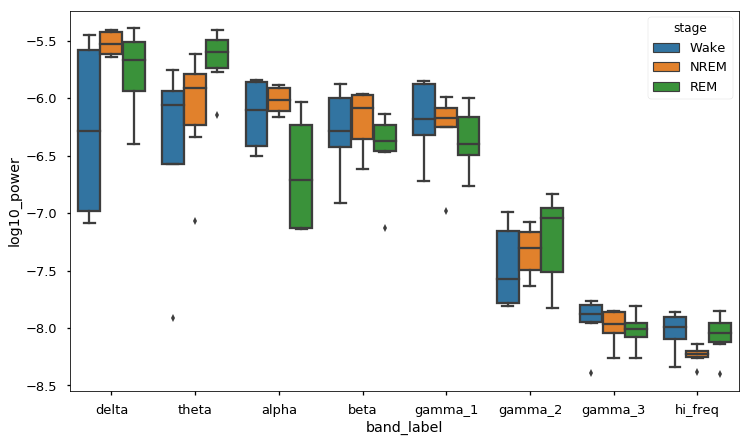

In [223]:
fig,ax = plt.subplots(1,1,figsize=(12,7))
sns.boxplot(x='band_label',y='log10_power',hue='stage',data=optim_df[optim_df.model.isin(good_models)],whis=1.5)
plt.savefig('band_power_optim_inp.png',dpi=150)
# plt.yscale('log')
# plt.ylim(10**-10,10**-5)

In [ ]:
fig,axs = plt.subplots(9,1,figsize=(10,35),sharey=True)
for i in np.arange(10):
    for ax,j in zip(axs,np.arange(9)):
        ax.plot(np.arange(8),scaler.inverse_transform(null_optim[i,j]))
#         ax.set_yscale('log')

(4, 8)


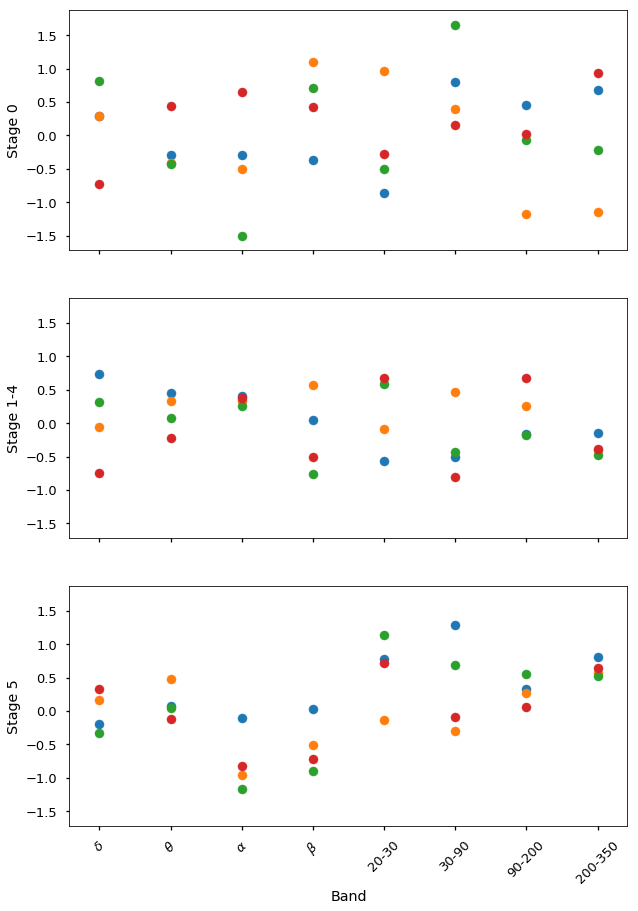

In [129]:
sns.set_context('talk')
c0 = inp_optim[0]
c1 = inp_optim[1]
c2 = inp_optim[2]
print(c2.shape)
band_labels=[
    r'$\delta$',
    r'$\theta$',
    r'$\alpha$',
    r'$\beta$',
    '20-30',
    '30-90',
    '90-200',
    '200-350',
]

stages = ['0','1-4','5']


fig,axs = plt.subplots(3,1,figsize=(10,15),sharex=True,sharey=True)
for i in np.arange(4):
    axs[0].scatter(np.arange(8),c0[i])
    axs[1].scatter(np.arange(8),c1[i])
    axs[2].scatter(np.arange(8),c2[i])
    axs[2].set_xlabel('Band')
    axs[2].set_xticklabels(band_labels)
    axs[2].set_xticks(np.arange(8))
    plt.xticks(rotation=45)
    [ax.set_ylabel('Stage '+lab) for ax,lab in zip(axs,stages)]
#     [ax.set_yscale('log') for ax in axs]
#     [ax.set_ylim(10**-11,10**-3) for ax in axs]

In [ ]:
idxs_stages = [dat['stages_simple']==i for i in [0,2,5]]

In [ ]:
dat['pows'][idxs_stages[2]].shape
VI = np.linalg.inv(np.cov(c0))

In [ ]:
mh_dist = []
for slc,c in zip(idxs_stages,inp_optim):
    src = dat['pows']
    vs = [scaler.inverse_transform(c[i]) for i in np.arange(9)]
    mhds = [distance.mahalanobis(v,src.mean(axis=0),np.cov(src.T)) for v in vs]
    print(mhds)
    mh_dist.append(mhds)

In [ ]:
mhds = [distance.mahalanobis(v,c2.mean(axis=0),np.cov(c2.T)) for v in c0]
plt.scatter(np.zeros(9),mhds)

In [ ]:
np.cov(s.T).shape

In [ ]:
for i in np.arange(3):
    sns.stripplot(np.ones(9)*i,mh_dist[i],jitter=True)
    plt.yscale('log')